# Springboard Time Series - 'Cowboy Cigarettes' Case Study 

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
os.getcwd()

'C:\\Users\\ligeo\\SpringBoard\\01_case_studies\\Cowboy Cigarettes - A Time Series Investigation'

In [3]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 62D0-961B

 Directory of C:\Users\ligeo\SpringBoard\01_case_studies\Cowboy Cigarettes - A Time Series Investigation

03/24/2022  04:57 PM    <DIR>          .
03/24/2022  04:57 PM    <DIR>          ..
03/23/2022  05:16 PM    <DIR>          .ipynb_checkpoints
03/24/2022  04:51 PM            65,263 Cowboy Cigarettes Case Study - Tier 1.ipynb
03/24/2022  04:57 PM           426,078 Cowboy Cigarettes Case Study - Tier 3.ipynb
03/24/2022  04:22 PM           396,705 Cowboy Cigarettes Case Study.ipynb
12/09/2021  04:25 PM             2,929 CowboyCigsData.csv
               4 File(s)        890,975 bytes
               3 Dir(s)  34,217,295,872 bytes free


In [4]:
cigData = pd.read_csv("CowboyCigsData.csv", index_col='Time', parse_dates=True)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [5]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  144 non-null    int64
 1   #CigSales   144 non-null    int64
dtypes: int64(2)
memory usage: 3.4 KB


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

In [6]:
cigData.head()

,Unnamed: 0,#CigSales
Time,,
1949-01-01,0,1000112
1949-02-01,1,1000118
1949-03-01,2,1000132
1949-04-01,3,1000129
1949-05-01,4,1000121


Check out the columns feature of the data. How many columns are there? 

In [7]:
cigData.columns 

Index(['Unnamed: 0', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [8]:
cigData.dtypes 

Unnamed: 0    int64
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [9]:
cigData.isnull().any()

Unnamed: 0    False
#CigSales     False
dtype: bool

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [10]:
cigData.drop(['Unnamed: 0'], axis=1, inplace=True)

In [11]:
cigData = cigData.reset_index()

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [12]:
# Now Give Column[0] a new lablel name: Month
cigData.rename(columns = {'#CigSales': 'CigSales', 'Time': 'Month'}, inplace = True)

Call a head() to check this has worked. 

In [13]:
cigData.head()

,Month,CigSales
0,1949-01-01,1000112
1,1949-02-01,1000118
2,1949-03-01,1000132
3,1949-04-01,1000129
4,1949-05-01,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [14]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace = True)

In [15]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [16]:
y = cigData['CigSales']

Check the type of our new variable. 

In [17]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [18]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

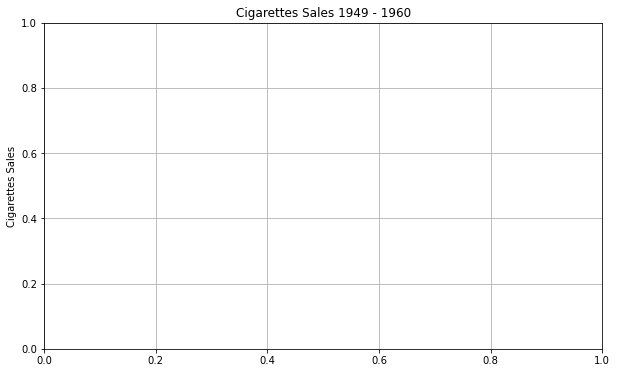

In [19]:
plt.figure(figsize=(10,6))
plt.ylabel('Cigarettes Sales')
plt.grid(True)
plt.title('Cigarettes Sales 1949 - 1960');

**Cowboy Cigarettes Sales Summary:**
 - Generally, there is a trend upwards in cigarette sales from Cowboy Cigarettes.
 - Cigarette sales are always higher in Q3 of every year compared to other quarters between 1949-1960.

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

We can see that, generally, **there is a trend upwards** in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations.**These seasonal fluctuations come in a repeated pattern**. Work out when seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is traveling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 
**as time progresses, the general trend seems to be increasing at a rate that's also increasing**

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

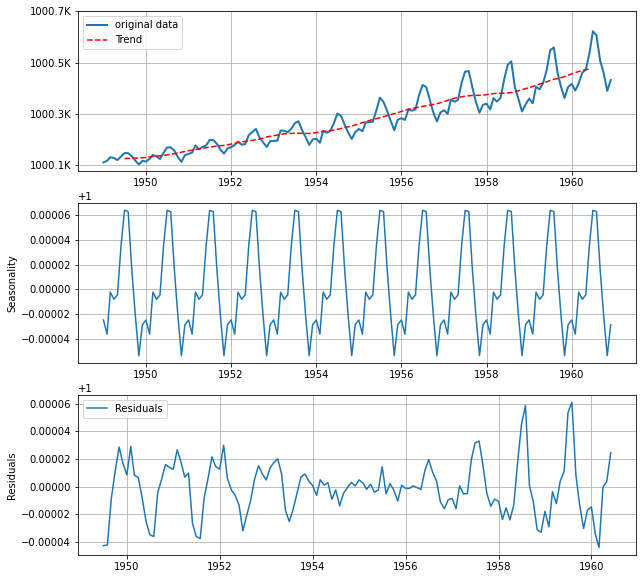

In [20]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose 

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 

decomposition = seasonal_decompose(y, model='multiplicative')

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(y, label = 'original data', linewidth=2)
plt.legend(loc = 'best')
plt.grid(True)
plt.plot(trend, label = 'Trend', color='r', linestyle='dashed')
plt.legend(loc = 'best')
plt.yticks([1000100, 1000300, 1000500, 1000700],
          ['1000.1K', '1000.3K', '1000.5K', '1000.7K'])
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(seasonal, label = 'seasonality')

#plt.legend(loc = 'lower left')
plt.ylabel('Seasonality')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.ylabel('Residuals')
plt.grid(True);
#plt.tight_layout()



In [21]:
# fig, ax = plt.subplots(4, figsize=(10,20))

#for i, attrib, name in zip([i for i in range(4)],
#                        [y, trend, seasonal, residual], 
#                        ['observed', 'trend', 'seasonal', 'residuals']):
#    ax[i].plot(attrib)
#    ax[i].set_ylabel(name)    

**Seasonal_decompose Drawback:**
As seen in the Trend graph above, 'Trend' appears missing the first 6 and the last 6 months.

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [22]:
from statsmodels.tsa.stattools import kpss
kpss(y)
# result = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
# for key, value in kpsstest[3].items():
#     result['Critical Value (%s)'%key] = value
# print (result)  

C:\Users\ligeo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1999: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

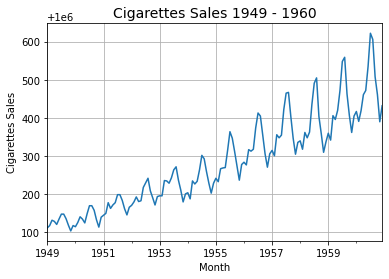

In [23]:
y.plot(grid=True)
plt.ylabel('Cigarettes Sales')
plt.title('Cigarettes Sales 1949 - 1960', fontsize=14);

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often used way of getting rid of changing variance is to take the natural log of all the values in our dataset.

In [24]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

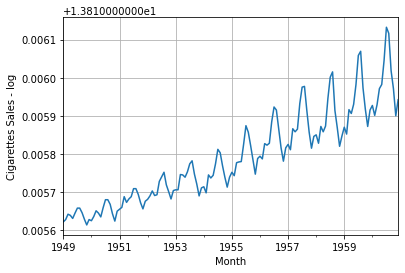

In [25]:
y_log.plot(grid=True)
plt.ylabel('Cigarettes Sales - log');

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [26]:
y_log_diff = y_log.diff().dropna()
y_log_diff

Month
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
1949-06-01    0.000014
                ...   
1960-08-01   -0.000016
1960-09-01   -0.000098
1960-10-01   -0.000047
1960-11-01   -0.000071
1960-12-01    0.000042
Name: CigSales, Length: 143, dtype: float64

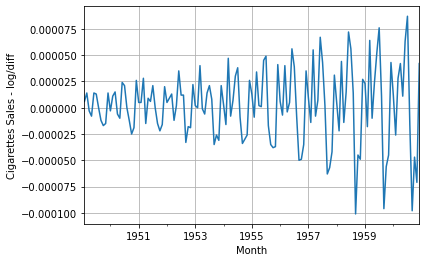

In [27]:
y_log_diff.plot(grid=True)
plt.ylabel('Cigarettes Sales - log/diff');

In [28]:
kpss(y_log_diff)

C:\Users\ligeo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2003: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.02389767420757057,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [29]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA # from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model

In [30]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    
    # make predictions
    predictions = list()
    for i in range(len(test)): #timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [31]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                print(order)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.11f' % (order,mse)) # .3f changed to 11f to show the details of MSE
                except:
                    continue
    return print('Best ARIMA%s MSE=%.11f' % (best_cfg, best_score))# .3f changed to 11f to show the details of MSE

In [32]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# p_values = [x for x in range(0, 3)]
# d_values = [x for x in range(0, 3)]
# q_values = [x for x in range(0, 3)]

In [33]:
import itertools
p = range(1,3)
d = q = range(1, 2)
S = 12
pdq = list(itertools.product(p, d, q))
pdq = [(x[0],x[1], x[2]) for x in pdq]
seasonal_pdq = [(x[0], x[1],x[2],S) for x in pdq]

print(pdq)

[(1, 1, 1), (2, 1, 1)]


In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

params = []
param_seasonals = []
aics = []
bics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,order=param,seasonal_order=param_seasonal)
            results = mod.fit()
            params.append(param)
            param_seasonals.append(param_seasonal)
            aics.append(results.aic)
            bics.append(results.bic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
            
df_aic_bic = pd.DataFrame([params, param_seasonals, aics, bics],index=['param', 'param_seasonal', 'aic', 'bic']).T
df_aic_bic.sort_values(by='aic', ascending=True).head(10)

,param,param_seasonal,aic,bic
2,"(2, 1, 1)","(1, 1, 1, 12)",1022.257443,1039.508627
3,"(2, 1, 1)","(2, 1, 1, 12)",1025.994506,1046.120887
0,"(1, 1, 1)","(1, 1, 1, 12)",1028.954815,1043.330801
1,"(1, 1, 1)","(2, 1, 1, 12)",1029.170744,1046.421928


In [35]:
df_aic_bic.loc[(df_aic_bic.aic == df_aic_bic.aic.min()) | (df_aic_bic.bic == df_aic_bic.bic.min())]

,param,param_seasonal,aic,bic
2,"(2, 1, 1)","(1, 1, 1, 12)",1022.257443,1039.508627


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [36]:
#let's fit our model using (2, 1, 1)	(1, 1, 1, 12): # SARIMAX for non-stationay time series
model = SARIMAX(y,  order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend='t')
results = model.fit()

We can take a look at a summary of the model this library has built around our data.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           CigSales   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -505.429
Date:                            Thu, 24 Mar 2022   AIC                           1024.858
Time:                                    16:58:16   BIC                           1044.984
Sample:                                01-01-1949   HQIC                          1033.036
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.390      0.696      -0.001       0.002
ar.L1          0.6959      0.066     10.559      0.000       0.567       0.825
ar.L2          0.1286      0.064      2.021      0.043       0.004       0.253
ma.L1         -0.9839      0.066    -14.847      0.000      -1.114      -0.854
ar.S.L12      -0.9937      0.203     -4.897      0.000      -1.391      -0.596
ma.S.L12       0.9695      0.522      1.857      0.063      -0.054       1.993
sigma2       105.2210     30.623      3.436      0.001      45.201     165.241
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):                18.61
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.30
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [38]:
pred = results.get_prediction(start=pd.to_datetime('1951-01-01'), dynamic=False)
pred_ci = pred.conf_int()

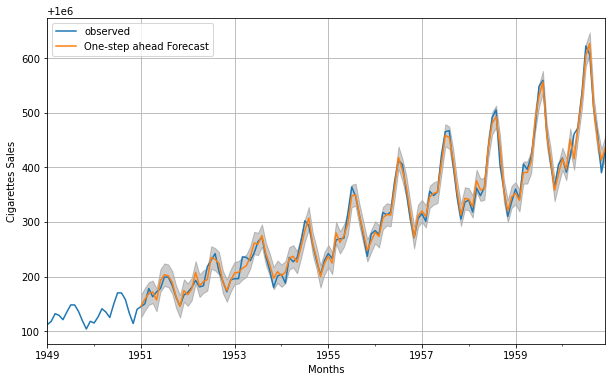

In [39]:
plt.figure(figsize=(10,6))
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Months')
ax.set_ylabel('Cigarettes Sales')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

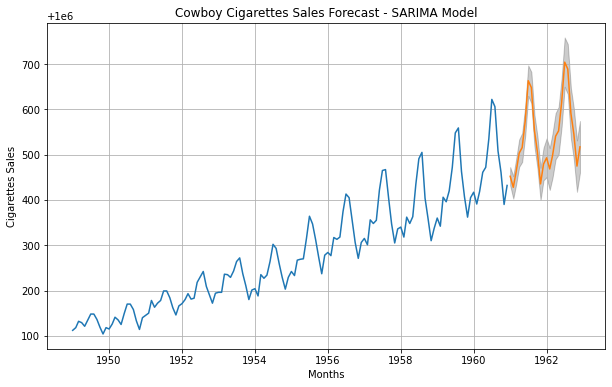

In [40]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

forecast = results.forecast(24)
forecast_ci= results.get_forecast(steps=24).conf_int()
mean_forcast = results.get_forecast(steps=24).predicted_mean

forecast_period = 24

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(10,6))
plt.plot(y, label='original')
plt.plot(forecast, label = 'forecasting')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],color='k', alpha=0.2)

plt.grid(True)
plt.title('Cowboy Cigarettes Sales Forecast - SARIMA Model')
plt.xlabel('Months')
plt.ylabel('Cigarettes Sales')
plt.show();

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 